# Import required libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import collections
import cv2
import gym
from gym import wrappers
from IPython import display


import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Classes

## Class: RepeatActionAndMaxFrame

In [2]:
class RepeatActionAndMaxFrame(gym.Wrapper):
    def __init__(self, env=None, repeat=4, clip_reward=False, no_ops=0,
                 fire_first=False):
        """
        env: Environment to add wrapper around
        repeat: Number of times each action is executed 
        clip_reward: Boolean. If True, clip reward to +/-1 range
        no_ops:
        fire_first:
        """
        super(RepeatActionAndMaxFrame, self).__init__(env)
        self.repeat = repeat
        self.shape = env.observation_space.low.shape # Shape of observation from environment
        self.frame_buffer = np.zeros_like((2, self.shape)) # Initialize frame_buffer
        self.clip_reward = clip_reward
        self.no_ops = no_ops
        self.fire_first = fire_first

    def step(self, action):
        """
        Executes action self.repeat times and captures total reward in t_reward
        Reward is clipped if self.clip_reward is True
        """
        t_reward = 0.0 # Initialize total reward over repeated actions to zero
        done = False
        for i in range(self.repeat): # Repeat actions 'self.repeat' times
            obs, reward, done, info = self.env.step(action)
            if self.clip_reward:
                reward = np.clip(np.array([reward]), -1, 1)[0]
            t_reward += reward # Increment t_reward with current reward
            idx = i % 2
            self.frame_buffer[idx] = obs # Frame_buffer updated with last two observations
            if done:
                break

        max_frame = np.maximum(self.frame_buffer[0], self.frame_buffer[1]) # Take maximum of last two frames
        return max_frame, t_reward, done, info

    def reset(self):
        """
        Wrapper for environment reset
        """
        obs = self.env.reset() # Reset environment
        no_ops = np.random.randint(self.no_ops) + 1 if self.no_ops > 0 else 0
        for _ in range(no_ops):
            _, _, done, _ = self.env.step(0)
            if done:
                self.env.reset()
        if self.fire_first:
            assert self.env.unwrapped.get_action_meanings()[1] == 'FIRE'
            obs, _, _, _ = self.env.step(1)

        self.frame_buffer = np.zeros_like((2,self.shape)) # Initialize frame buffer to zeros
        self.frame_buffer[0] = obs # Update frame buffer with first observation after reset

        return obs


## Class: preprocessFrame

In [3]:
class PreprocessFrame(gym.ObservationWrapper):
    def __init__(self, shape, env=None):
        """
        Class to pre-process frame.
        Frame converted from RGB to grayscale, resized to new shape in C,H,W format
        
        Arguments:
            shape: Shape to pre-process frame to
            env: Environment which will be wrapped
        """
        super(PreprocessFrame, self).__init__(env)
        self.shape = (shape[2], shape[0], shape[1]) # Change to C,H,W format
        # Change observation space to match new shape and dtype to float32 with range = [0.0, 1.0]
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0,shape=self.shape, dtype=np.float32)

    def observation(self, obs):
        """
        obs converted from RGB to grayscale and resized to new shape in C,H,W format
        
        Argument:
            obs: Input Frame in color format
        Output:
            new_obs: Output Frame in grayscale and C,H,W format
        """
        new_frame = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY) # Convert frame to grayscale
        resized_screen = cv2.resize(new_frame, self.shape[1:], interpolation=cv2.INTER_AREA) # Resize frame to new shape
        new_obs = np.array(resized_screen, dtype=np.uint8).reshape(self.shape)
        new_obs = new_obs / 255.0 # Convert to float32 in range [0.0, 1.0]

        return new_obs

## Class: StackFrames

In [4]:
class StackFrames(gym.ObservationWrapper):
    """
    Class to return stack of last 4 observations
    """
    def __init__(self, env, repeat):
        """
        Arguments: 
            env: Environment to wrap
            repeat: Number of observations to stack
        """
        super(StackFrames, self).__init__(env)
        self.observation_space = gym.spaces.Box(
                            env.observation_space.low.repeat(repeat, axis=0),
                            env.observation_space.high.repeat(repeat, axis=0),
                            dtype=np.float32)
        self.stack = collections.deque(maxlen=repeat)

    def reset(self):
        self.stack.clear()
        observation = self.env.reset()
        for _ in range(self.stack.maxlen):
            self.stack.append(observation)

        return np.array(self.stack).reshape(self.observation_space.low.shape)

    def observation(self, observation):
        """
        Append latest observation to stack
        """
        self.stack.append(observation)

        return np.array(self.stack).reshape(self.observation_space.low.shape)

## Class: DeepQNetwork

In [5]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, name, input_dims, chkpt_dir):
        super(DeepQNetwork, self).__init__()
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

        self.conv1 = nn.Conv2d(input_dims[0], 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

        fc_input_dims = self.calculate_conv_output_dims(input_dims)

        self.fc1 = nn.Linear(fc_input_dims, 512)
        self.fc2 = nn.Linear(512, n_actions)

        self.optimizer = optim.RMSprop(self.parameters(), lr=lr)

        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def calculate_conv_output_dims(self, input_dims):
        state = T.zeros(1, *input_dims)
        dims = self.conv1(state)
        dims = self.conv2(dims)
        dims = self.conv3(dims)
        return int(np.prod(dims.size()))

    def forward(self, state):
        conv1 = F.relu(self.conv1(state))
        conv2 = F.relu(self.conv2(conv1))
        conv3 = F.relu(self.conv3(conv2))
        # conv3 shape is BS x n_filters x H x W
        conv_state = conv3.view(conv3.size()[0], -1)
        # conv_state shape is BS x (n_filters * H * W)
        flat1 = F.relu(self.fc1(conv_state))
        actions = self.fc2(flat1)

        return actions

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

## Class: ReplayBuffer

In [6]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)
        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

## Class: DQNAgent

In [7]:
class DQNAgent(object):
    def __init__(self, gamma, epsilon, lr, n_actions, input_dims,
                 mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                 replace=1000, algo=None, env_name=None, chkpt_dir='tmp/dqn'):
        self.gamma = gamma # Discount Factor
        self.epsilon = epsilon # for eps-greedy action selection
        self.lr = lr # Learning Rate
        self.n_actions = n_actions # Number of actions
        self.input_dims = input_dims # Dimension of observations from wrapped environment
        self.batch_size = batch_size # Batch size to use while training
        self.eps_min = eps_min # Minimum eps-value to use while training
        self.eps_dec = eps_dec # Decay rate of epsilon
        self.replace_target_cnt = replace # Rate at which target network will be replaced
        self.algo = algo # Name of learning algorithm
        self.env_name = env_name # Name of environment
        self.chkpt_dir = chkpt_dir # Directory to save checkpoint files
        self.action_space = [i for i in range(n_actions)] # Action space
        self.learn_step_counter = 0 # Number of learning steps completed so far

        self.memory = ReplayBuffer(mem_size, input_dims) # Instantiate replay buffer object

        # Instantiate main DQN
        self.q_eval = DeepQNetwork(self.lr, self.n_actions, input_dims=self.input_dims,\
                                   name=self.env_name+'_'+self.algo+'_q_eval', chkpt_dir=self.chkpt_dir)
        # Instantiate target DQN
        self.q_next = DeepQNetwork(self.lr, self.n_actions, input_dims=self.input_dims,\
                                   name=self.env_name+'_'+self.algo+'_q_next', chkpt_dir=self.chkpt_dir)

    def choose_action(self, observation):
        """
        Perform epsilon-greedy action selection
        """
        if np.random.random() > self.epsilon: # Choose greedy action with probability '1 - epsilon'
            state = T.tensor([observation],dtype=T.float).to(self.q_eval.device)
            actions = self.q_eval.forward(state)
            action = T.argmax(actions).item()
        else: # Choose an action randomly with probability 'epsilon'
            action = np.random.choice(self.action_space)

        return action

    def store_transition(self, state, action, reward, state_, done):
        """
        Update replay memory buffer with latest entry
        """
        self.memory.store_transition(state, action, reward, state_, done)

    def replace_target_network(self):
        """
        Update target DQN weights with main DQN weights every 'replace_target_cnt' steps
        """
        if self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())
            
    def sample_memory(self):
        """
        Sample a random batch from replay memory
        """
        state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)
        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(new_state).to(self.q_eval.device)

        return states, actions, rewards, states_, dones            

    def decrement_epsilon(self):
        """
        Decrease epsilon after every learning step and clamp at eps_min
        """
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

    def save_models(self):
        """
        Save checkpoints for both DQN models
        """
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()

    def load_models(self):
        """
        Load checkpoints for both DQN models
        """
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()

    def learn(self):
        """
        Perform one learning step
        """
        # Start learning only after replay_memory has atleast 'batch_size' elements
        if self.memory.mem_cntr < self.batch_size:
            return
        self.q_eval.optimizer.zero_grad() # Reset optimizer gradients
        self.replace_target_network() # Replace target DQN weights with main DQN weights
        states, actions, rewards, states_, dones = self.sample_memory() # Sample a new batch from replay memory
        indices = np.arange(self.batch_size)

        q_pred = self.q_eval.forward(states)[indices, actions] # Q-values of current states
        q_next = self.q_next.forward(states_).max(dim=1)[0] # Q-values of next states
        q_next[dones] = 0.0 # Set terminal state q-values to 0.
        q_target = rewards + self.gamma*q_next # # Target Q-values for current states

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device) # MSE Loss between current and target Q-values
        loss.backward() # Compute gradients
        self.q_eval.optimizer.step() # Update weights
        
        self.learn_step_counter += 1 # Increment learning step counter by 1.
        self.decrement_epsilon()

# Functions

## make_env

In [8]:
def make_env(env_name, shape=(84,84,1), repeat=4, clip_rewards=False, no_ops=0, fire_first=False):
#     env = gym.make(env_name, render_mode = 'human') # Instantiate original environment from gym
    env = gym.make(env_name) # Instantiate original environment from gym    
    env = RepeatActionAndMaxFrame(env, repeat, clip_rewards, no_ops, fire_first) # Wrapper to repeat action, clip_rewards 
                                                                                 # and return max of latest two frames
    env = PreprocessFrame(shape, env) # Convert observation to grayscale and scale to new dimension in C,H,W format
    env = StackFrames(env, repeat) # Stack last n observations

    return env

# Verify Functions and Classes

## Verify Function: make_env

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(4, 84, 84) 0.0 False {'lives': 0, 'episode_frame_number': 8, 'frame_number': 8}


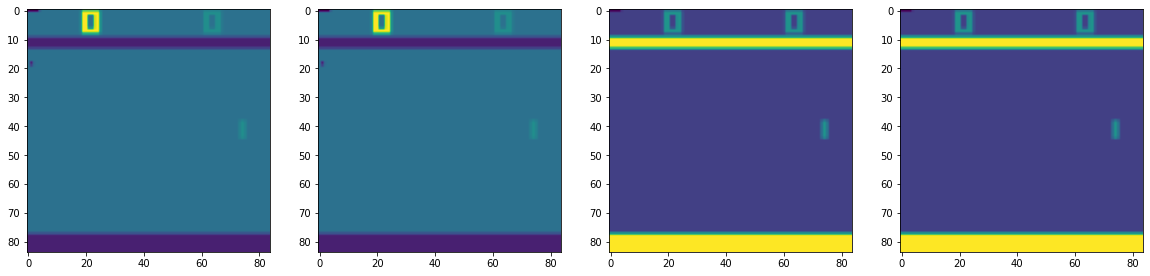

In [9]:
env = make_env('PongNoFrameskip-v4')
obs = env.reset()

s,r,d,i = env.step(0) # Run first step
s,r,d,i = env.step(0) # Run second step
print(s.shape, r, d, i)
fig,ax = plt.subplots(1, 4, figsize = (20, 8))
for ind in range(4):
    obs_temp = s[ind, :]
    ax[ind].imshow(obs_temp)

## Verify Class: DeepQNetwork

In [10]:
temp_model = DeepQNetwork(lr = 0.0001, n_actions = env.action_space.n, input_dims = env.observation_space.shape,\
                          name = '_q_eval', chkpt_dir = 'Models/')
temp_model

DeepQNetwork(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=6, bias=True)
  (loss): MSELoss()
)

## Verify Class: ReplayBuffer

In [11]:
rp_buff = ReplayBuffer(10, [1])
print(rp_buff.mem_size)
print(rp_buff.mem_cntr)
print(rp_buff.state_memory.shape)
print(rp_buff.new_state_memory.shape)
print(rp_buff.action_memory, rp_buff.reward_memory, rp_buff.terminal_memory)
print()

for ind in range(7):
    rp_buff.store_transition([ind], ind+1, ind+2, [ind + 3], ind % 2)

print(rp_buff.mem_cntr)
print()
for ind in range(rp_buff.mem_cntr):
    print(rp_buff.state_memory[ind], rp_buff.new_state_memory[ind], rp_buff.action_memory[ind],\
         rp_buff.reward_memory[ind], rp_buff.terminal_memory[ind])

10
0
(10, 1)
(10, 1)
[0 0 0 0 0 0 0 0 0 0] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [False False False False False False False False False False]

7

[0.] [3.] 1 2.0 False
[1.] [4.] 2 3.0 True
[2.] [5.] 3 4.0 False
[3.] [6.] 4 5.0 True
[4.] [7.] 5 6.0 False
[5.] [8.] 6 7.0 True
[6.] [9.] 7 8.0 False


In [12]:
rp_buff.sample_buffer(batch_size = 5)

(array([[6.],
        [1.],
        [3.],
        [5.],
        [2.]], dtype=float32),
 array([7, 2, 4, 6, 3], dtype=int64),
 array([8., 3., 5., 7., 4.], dtype=float32),
 array([[9.],
        [4.],
        [6.],
        [8.],
        [5.]], dtype=float32),
 array([False,  True,  True,  True, False]))

# Run training loop

In [13]:
env = make_env('PongNoFrameskip-v4')
obs = env.reset()
best_score = -np.inf # Reset best score
load_checkpoint = False
n_games = 10 # Number of games (episodes) to play 
n_steps = 0 # Number of time steps run till now
scores = [] # Placeholder to store cumulative rewards for each episode (no discounting)
steps_array = [] # Placeholder to store number of steps executed in each episode
eps_history = [] # Placeholder to store epsilon value of agent at the end of each episode

# Instantiate DQN agent
agent = DQNAgent(gamma = 0.99, epsilon = 1, lr = 1e-4, input_dims = (env.observation_space.shape),\
                 n_actions = env.action_space.n, mem_size = 50000, eps_min = 0.1, batch_size = 32,\
                 replace = 1000, eps_dec = 1e-5, chkpt_dir = 'models/', algo = 'DQNAgent',\
                 env_name = 'PongNoFrameskip-v4')

# Load saved model if load_checkpoint is true.
if load_checkpoint:
    agent.load_models()
    
for i in range(n_games): # Iterate through n_games (episodes)
    done = False # Reset 'done' flag
    observation = env.reset() # Reset environment at the start of the episode
    score = 0 # Initialize score to 0.
    while not done: # Loop till the end of the game (episode)
        action = agent.choose_action(observation) # Choose action based on eps-greedy policy
        observation_, reward, done, info = env.step(action) # Perform one step
        score += reward # Increment score of current episode
        if not load_checkpoint: # Update replay memory and perform one learning step
            agent.store_transition(observation, action, reward, observation_, done)
            agent.learn()
        observation = observation_ # Replace current observation with next observation
        n_steps += 1 # Update n_steps
        #print(n_steps, end = ", ")
    scores.append(score) # Update scores array at the end of current game
    steps_array.append(n_steps) # Update steps array at the end of current game
    eps_history.append(agent.epsilon) # Update eps_history
    avg_score = np.mean(scores[-100:]) 
    print('episode: ', i,'score: ', score, ' average score %.1f' % avg_score, 'best score %.2f' % best_score,\
          'epsilon %.2f' % agent.epsilon, 'steps', n_steps)
    if avg_score > best_score: # Update best_score if current episode score better than previous best_score
        if not load_checkpoint:
            #agent.save_models()
            best_score = avg_score

episode:  0 score:  -18.0  average score -18.0 best score -inf epsilon 0.99 steps 1107
episode:  1 score:  -20.0  average score -19.0 best score -18.00 epsilon 0.98 steps 2005
episode:  2 score:  -21.0  average score -19.7 best score -18.00 epsilon 0.97 steps 2887
episode:  3 score:  -21.0  average score -20.0 best score -18.00 epsilon 0.96 steps 3708
episode:  4 score:  -19.0  average score -19.8 best score -18.00 epsilon 0.95 steps 4647
episode:  5 score:  -21.0  average score -20.0 best score -18.00 epsilon 0.95 steps 5472
episode:  6 score:  -21.0  average score -20.1 best score -18.00 epsilon 0.94 steps 6283
episode:  7 score:  -21.0  average score -20.2 best score -18.00 epsilon 0.93 steps 7048
episode:  8 score:  -20.0  average score -20.2 best score -18.00 epsilon 0.92 steps 8296
episode:  9 score:  -21.0  average score -20.3 best score -18.00 epsilon 0.91 steps 9257


In [16]:
steps_array

[1107, 2005, 2887, 3708, 4647, 5472, 6283, 7048, 8296, 9257]

# Backup

## utils.py

In [ ]:
import collections
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gym

def plot_learning_curve(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Training Steps", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)

## main.py

In [ ]:
import gym
import numpy as np
from dqn_agent import DQNAgent
from utils import plot_learning_curve, make_env
from gym import wrappers

if __name__ == '__main__':
    env = make_env('PongNoFrameskip-v4')
    #env = gym.make('CartPole-v1')
    best_score = -np.inf
    load_checkpoint = False
    n_games = 250

    agent = DQNAgent(gamma=0.99, epsilon=1, lr=0.0001,
                     input_dims=(env.observation_space.shape),
                     n_actions=env.action_space.n, mem_size=50000, eps_min=0.1,
                     batch_size=32, replace=1000, eps_dec=1e-5,
                     chkpt_dir='models/', algo='DQNAgent',
                     env_name='PongNoFrameskip-v4')

    if load_checkpoint:
        agent.load_models()

    fname = agent.algo + '_' + agent.env_name + '_lr' + str(agent.lr) +'_' \
            + str(n_games) + 'games'
    figure_file = 'plots/' + fname + '.png'
    # if you want to record video of your agent playing, do a mkdir tmp && mkdir tmp/dqn-video
    # and uncomment the following 2 lines.
    #env = wrappers.Monitor(env, "tmp/dqn-video",
    #                    video_callable=lambda episode_id: True, force=True)
    n_steps = 0
    scores, eps_history, steps_array = [], [], []

    for i in range(n_games):
        done = False
        observation = env.reset()

        score = 0
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward

            if not load_checkpoint:
                agent.store_transition(observation, action,
                                     reward, observation_, done)
                agent.learn()
            observation = observation_
            n_steps += 1
        scores.append(score)
        steps_array.append(n_steps)

        avg_score = np.mean(scores[-100:])
        print('episode: ', i,'score: ', score,
             ' average score %.1f' % avg_score, 'best score %.2f' % best_score,
            'epsilon %.2f' % agent.epsilon, 'steps', n_steps)

        if avg_score > best_score:
            if not load_checkpoint:
                agent.save_models()
            best_score = avg_score

        eps_history.append(agent.epsilon)

    x = [i+1 for i in range(len(scores))]
    plot_learning_curve(steps_array, scores, eps_history, figure_file)
